# MNIST Handwriten Digits Classifier

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model_root_dir = '/notebooks/my-notebooks/MNIST/'
model_logdir = model_root_dir+'logdir/'

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(model_root_dir+'MNIST_data', one_hot=True)

Extracting /notebooks/my-notebooks/MNIST/MNIST_data/train-images-idx3-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def conv_pool_layer(inputs, filters=32, kernal_size=[5,5], name='conv'):
    
    with tf.name_scope(name):
        
        conv = tf.layers.conv2d(inputs=inputs,
                                 filters=filters,
                                 kernel_size=kernal_size,
                                 padding="same",
                                 activation=tf.nn.relu)

        pool = tf.layers.max_pooling2d(inputs=conv, pool_size=[2, 2], strides=2)

        return(pool)

In [5]:
def fc(inputs, units, activation=None, name='fc'):
    
    with tf.name_scope(name):
        
        dense = tf.layers.dense(inputs=inputs, units=units, activation=activation)
        return(dense)

In [6]:
def plot(data, heading=None, figsize=None):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(data)
    ax.grid(True)
    ax.set_title(heading)

In [7]:
def conv_model(data, dropout):
    
    X_image = tf.reshape(data, [-1,image_size,image_size,1])
    
    conv1 = conv_pool_layer(inputs=X_image, filters=32, name='conv1')
    conv2 = conv_pool_layer(inputs=conv1, filters=64, name='conv2')
    
    conv2_flat = tf.reshape(conv2, [-1, 7 * 7 * 64])
    
    fc1 = fc(inputs=conv2_flat, units=1024, activation=tf.nn.relu, name='fc1')
    dropout_fc1 = tf.layers.dropout(inputs=fc1, rate=dropout)
    
    logits = fc(inputs=dropout_fc1, units=10, name='output')
    
    return(logits, dropout_fc1)

In [8]:
image_size = 28
num_classes = 10

LABELS = os.path.join(os.getcwd(), "labels_1024.tsv")
SPRITES = os.path.join(os.getcwd(), "sprite_1024.png")

batch_size = 100
learning_rate = 0.1
iterations = 1001

In [9]:
hparam_str = 'c2,fc2,lr_%f' % (learning_rate)
previous_runs = list(f for f in os.listdir(model_logdir) if f.startswith('run'))

if len(previous_runs) == 0:
    run_number = 1  
else:
    run_number = max([int(s[4:6]) for s in previous_runs]) + 1

LOGDIR = '%srun_%02d,' % (model_logdir, run_number)+hparam_str

In [10]:
tf.reset_default_graph()

In [11]:
X_placeholder = tf.placeholder(shape=[None, image_size**2], dtype=tf.float32, name='X_placeholder')
Y_placeholder = tf.placeholder(shape=[None, num_classes], dtype=tf.int64, name='Y_placeholder')

dropout_placeholder = tf.placeholder_with_default(input=1.0, shape=[], name='dropout_placeholder')

X_image = tf.reshape(X_placeholder, shape=[-1,28,28, 1])
tf.summary.image('input', X_image, 3)

Y_prediction, embedding_input = conv_model(X_placeholder, dropout_placeholder)

embedding_size = 1024

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_placeholder, logits=Y_prediction, name='loss'))
    tf.summary.scalar('loss', loss)
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(Y_prediction, 1), tf.argmax(Y_placeholder, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [12]:
summ = tf.summary.merge_all()

embedding = tf.Variable(tf.zeros([1024, embedding_size]), name="test_embedding")
assignment = embedding.assign(embedding_input)

sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter(LOGDIR)
writer.add_graph(sess.graph)

config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
embedding_config = config.embeddings.add()
embedding_config.tensor_name = embedding.name
embedding_config.sprite.image_path = SPRITES
embedding_config.metadata_path = LABELS
embedding_config.sprite.single_image_dim.extend([image_size, image_size])
tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

step 0 loss 2.2908611 accuracy 9.92%
step 50 loss 0.47318298 accuracy 88.16%
step 100 loss 0.2625376 accuracy 92.72%
step 150 loss 0.1588922 accuracy 94.52%
step 200 loss 0.07400411 accuracy 96.5%
step 250 loss 0.090715 accuracy 96.64%
step 300 loss 0.08278704 accuracy 97.0%
step 350 loss 0.09874865 accuracy 97.58%
step 400 loss 0.09983973 accuracy 97.54%
step 450 loss 0.08245747 accuracy 97.78%
step 500 loss 0.07655444 accuracy 98.1%
step 550 loss 0.04308767 accuracy 98.16%
step 600 loss 0.028922252 accuracy 97.84%
step 650 loss 0.04364989 accuracy 98.18%
step 700 loss 0.102858745 accuracy 98.42%
step 750 loss 0.023483133 accuracy 98.38%
step 800 loss 0.058277745 accuracy 97.78%
step 850 loss 0.031283602 accuracy 98.5%
step 900 loss 0.112316206 accuracy 98.4%
step 950 loss 0.009488374 accuracy 98.66%
step 1000 loss 0.0400127 accuracy 98.68%


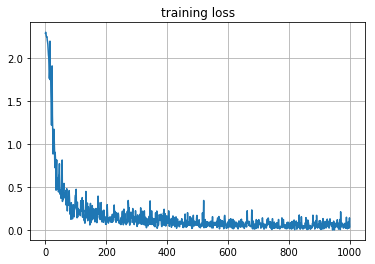

In [13]:
losses = np.array([])

for idx in range(iterations):
            
    batch_xs, batch_ys = mnist.train.next_batch(batch_size, shuffle=True)
    
    _, _loss, _summary = sess.run([train_step, loss, summ], 
                                  feed_dict={
                                      X_placeholder: batch_xs,
                                      Y_placeholder: batch_ys,
                                      dropout_placeholder : 0.4
                                  })

    if idx % (iterations/20) == 0:

        _accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.validation.images,
                                                  Y_placeholder : mnist.validation.labels,
                                                  dropout_placeholder : 1.0
                                                 })

        print 'step', idx, 'loss', np.mean(_loss), 'accuracy', str(round(100*_accuracy,2))+'%'
        
    if idx % 20 == 0:
        writer.add_summary(_summary, idx)
        
    if idx % 500 == 0:
        sess.run(assignment, feed_dict={X_placeholder: mnist.test.images[:1024], Y_placeholder: mnist.test.labels[:1024]})
        saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), idx)
        
    losses = np.append(losses, np.mean(_loss))

plot(data=losses, heading='training loss')

In [14]:
_accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.test.images,
                                          Y_placeholder : mnist.test.labels,
                                          dropout_placeholder : 1.0
                                         })

print str(round(100*_accuracy,2))+'%'

98.41%
